using newly pre-processed dataset

In [17]:
from datetime import datetime, timedelta
import Dataloader_ricequant
import pandas as pd
import rqdatac as rq
from constants import *
import scipy
import statsmodels as sm
import numpy as np
import seaborn as sns
import pathos
from tqdm.notebook import tqdm
import multiprocessing
import pickle
import matplotlib.pyplot as plt
from alphalens import tears
from alphalens import utils

In [19]:
#Get industry data
indus = Dataloader_ricequant.load_industry_mapping()
indus = indus.reset_index()
indus.columns = ['stock', 'second_indus', 'primary_indus']
indus

,stock,second_indus,primary_indus
0,000998.XSHE,A01,A
1,002041.XSHE,A01,A
2,002772.XSHE,A01,A
3,300087.XSHE,A01,A
4,300189.XSHE,A01,A
...,...,...,...
4634,600620.XSHG,S90,S
4635,600673.XSHG,S90,S
4636,600766.XSHG,S90,S
4637,600770.XSHG,S90,S


In [20]:
#重新声明我们要测试的TESTING_FACTOR
TESTING_FACTOR = ['return_on_asset_ttm']

In [21]:
#Read the dataframe from .h5 file stored in raw_data
name = TESTING_FACTOR[0]
df = pd.read_hdf(DATAPATH + f'raw_data/' + name + f'.h5', key='stock')
df

PE_TTM     PS_TTM      PC_TTM        PB  \
date       stock                                                     
2011-01-31 000001.XSHE   8.472443   3.130145    1.135280  1.659888   
           000002.XSHE  15.974212   2.161218  -28.217419  2.239730   
           000005.XSHE -50.220236  74.174521  154.559458  4.739232   
           000006.XSHE  15.004099   1.857741  264.008848  2.585111   
           000009.XSHE  61.799492   6.153490  -26.665920  8.004300   
...                           ...        ...         ...       ...   
2020-11-30 688368.XSHG        NaN        NaN         NaN       NaN   
           688369.XSHG        NaN        NaN         NaN       NaN   
           688388.XSHG        NaN        NaN         NaN       NaN   
           688389.XSHG        NaN        NaN         NaN       NaN   
           688399.XSHG        NaN        NaN         NaN       NaN   

                        market_value    open   close  next_period_open  \
date       stock                                                         
2011-01-31 000001.XSHE  5.335556e+10   15.20   15.31             15.81   
           000002.XSHE  7.937809e+10    8.25    8.20              8.13   
           000005.XSHE  3.200168e+09    3.46    3.50              4.28   
           000006.XSHE  5.409109e+09    7.15    7.11              7.22   
           000009.XSHE  1.937173e+10   17.05   17.76             23.50   
...                              ...     ...     ...               ...   
2020-11-30 688368.XSHG  1.207400e+10  210.19  196.00            159.42   
           688369.XSHG  5.361000e+09   69.03   69.63             77.35   
           688388.XSHG  1.385300e+10   62.18   60.00             86.90   
           688389.XSHG  8.246000e+09   19.33   19.53             21.20   
           688399.XSHG  1.083200e+10  185.00  184.79            190.40   

                        next_period_return  return_on_asset_ttm  
date       stock                                                 
2011-01-31 000001.XSHE            0.032658            -1.020857  
           000002.XSHE           -0.008537            -0.287004  
           000005.XSHE            0.222857            -1.541651  
           000006.XSHE            0.015471            -0.294009  
           000009.XSHE            0.323198             0.025249  
...                                    ...                  ...  
2020-11-30 688368.XSHG           -0.186633            -0.110882  
           688369.XSHG            0.110872             0.274640  
           688388.XSHG            0.448333             0.225311  
           688389.XSHG            0.085509             0.578948  
           688399.XSHG            0.030359             4.202822  

[301709 rows x 10 columns]

In [22]:
#Get factor data
factor = df[TESTING_FACTOR[0]].to_frame()
factor

return_on_asset_ttm
date       stock                           
2011-01-31 000001.XSHE            -1.020857
           000002.XSHE            -0.287004
           000005.XSHE            -1.541651
           000006.XSHE            -0.294009
           000009.XSHE             0.025249
...                                     ...
2020-11-30 688368.XSHG            -0.110882
           688369.XSHG             0.274640
           688388.XSHG             0.225311
           688389.XSHG             0.578948
           688399.XSHG             4.202822

[301709 rows x 1 columns]

In [23]:
#Get price data
price = df['close'].unstack()
price

stock,000001.XSHE,000002.XSHE,000005.XSHE,000006.XSHE,000009.XSHE,000011.XSHE,000012.XSHE,000014.XSHE,000016.XSHE,000019.XSHE,...,688118.XSHG,688123.XSHG,688198.XSHG,688218.XSHG,688258.XSHG,688268.XSHG,688310.XSHG,688357.XSHG,688358.XSHG,688399.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2011-01-31,15.31,8.20,3.50,7.11,17.76,7.01,18.98,9.08,4.54,10.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-28,15.93,8.16,4.25,7.22,21.88,7.56,22.36,9.86,5.10,11.68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-03-31,16.08,NaN,4.05,7.84,18.19,7.73,20.60,10.07,4.90,10.57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-04-29,18.20,8.48,3.86,7.77,17.47,9.29,18.49,9.04,4.77,11.86,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-05-31,17.66,7.84,NaN,7.05,16.22,10.59,15.98,7.95,4.54,10.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-31,13.34,26.84,2.92,8.28,8.37,26.05,6.04,13.40,7.22,9.50,...,40.65,75.95,102.72,27.11,94.11,95.52,47.60,53.92,78.85,400.00
2020-08-31,15.08,27.27,2.94,6.39,7.65,20.17,5.86,11.08,7.15,9.93,...,40.88,67.37,96.60,26.23,88.54,73.46,39.26,75.10,64.80,244.26
2020-09-30,15.17,28.02,2.58,6.43,7.00,17.86,5.62,10.49,6.06,8.30,...,35.70,61.46,90.80,24.30,73.97,66.00,34.55,73.07,56.92,259.38


In [24]:
#Merge industry index data into the dataframe
df1 = df.reset_index()
result = pd.merge(df1, indus, how= 'left', on=['stock'])
result = result.set_index(INDEX_COLS).sort_index()
result

PE_TTM     PS_TTM      PC_TTM        PB  \
date       stock                                                     
2011-01-31 000001.XSHE   8.472443   3.130145    1.135280  1.659888   
           000002.XSHE  15.974212   2.161218  -28.217419  2.239730   
           000005.XSHE -50.220236  74.174521  154.559458  4.739232   
           000006.XSHE  15.004099   1.857741  264.008848  2.585111   
           000009.XSHE  61.799492   6.153490  -26.665920  8.004300   
...                           ...        ...         ...       ...   
2020-11-30 688368.XSHG        NaN        NaN         NaN       NaN   
           688369.XSHG        NaN        NaN         NaN       NaN   
           688388.XSHG        NaN        NaN         NaN       NaN   
           688389.XSHG        NaN        NaN         NaN       NaN   
           688399.XSHG        NaN        NaN         NaN       NaN   

                        market_value    open   close  next_period_open  \
date       stock                                                         
2011-01-31 000001.XSHE  5.335556e+10   15.20   15.31             15.81   
           000002.XSHE  7.937809e+10    8.25    8.20              8.13   
           000005.XSHE  3.200168e+09    3.46    3.50              4.28   
           000006.XSHE  5.409109e+09    7.15    7.11              7.22   
           000009.XSHE  1.937173e+10   17.05   17.76             23.50   
...                              ...     ...     ...               ...   
2020-11-30 688368.XSHG  1.207400e+10  210.19  196.00            159.42   
           688369.XSHG  5.361000e+09   69.03   69.63             77.35   
           688388.XSHG  1.385300e+10   62.18   60.00             86.90   
           688389.XSHG  8.246000e+09   19.33   19.53             21.20   
           688399.XSHG  1.083200e+10  185.00  184.79            190.40   

                        next_period_return  return_on_asset_ttm second_indus  \
date       stock                                                               
2011-01-31 000001.XSHE            0.032658            -1.020857          J66   
           000002.XSHE           -0.008537            -0.287004          K70   
           000005.XSHE            0.222857            -1.541651          N77   
           000006.XSHE            0.015471            -0.294009          K70   
           000009.XSHE            0.323198             0.025249          S90   
...                                    ...                  ...          ...   
2020-11-30 688368.XSHG           -0.186633            -0.110882          I65   
           688369.XSHG            0.110872             0.274640          I65   
           688388.XSHG            0.448333             0.225311          C39   
           688389.XSHG            0.085509             0.578948          C35   
           688399.XSHG            0.030359             4.202822          C27   

                       primary_indus  
date       stock                      
2011-01-31 000001.XSHE             J  
           000002.XSHE             K  
           000005.XSHE             N  
           000006.XSHE             K  
           000009.XSHE             S  
...                              ...  
2020-11-30 688368.XSHG             I  
           688369.XSHG             I  
           688388.XSHG             C  
           688389.XSHG             C  
           688399.XSHG             C  

[301709 rows x 12 columns]

In [25]:
#Get industry data 
indus = result['primary_indus'].to_frame()
indus

primary_indus
date       stock                    
2011-01-31 000001.XSHE             J
           000002.XSHE             K
           000005.XSHE             N
           000006.XSHE             K
           000009.XSHE             S
...                              ...
2020-11-30 688368.XSHG             I
           688369.XSHG             I
           688388.XSHG             C
           688389.XSHG             C
           688399.XSHG             C

[301709 rows x 1 columns]

In [26]:
data = utils.get_clean_factor_and_forward_returns(factor = factor,
prices = price,
groupby=indus,
binning_by_group=True,
quantiles=5,
max_loss=100)

Dropped 13.1% entries from factor data: 13.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 10000.0%, not exceeded: OK!


Returns Analysis


,1D,5D,10D
Ann. alpha,-0.491,-0.526,-0.591
beta,-0.058,-0.025,-0.118
Mean Period Wise Return Top Quantile (bps),-51.678,-43.780,-42.760
Mean Period Wise Return Bottom Quantile (bps),22.122,41.978,42.795
Mean Period Wise Spread (bps),-73.800,-85.814,-86.804


<Figure size 432x288 with 0 Axes>

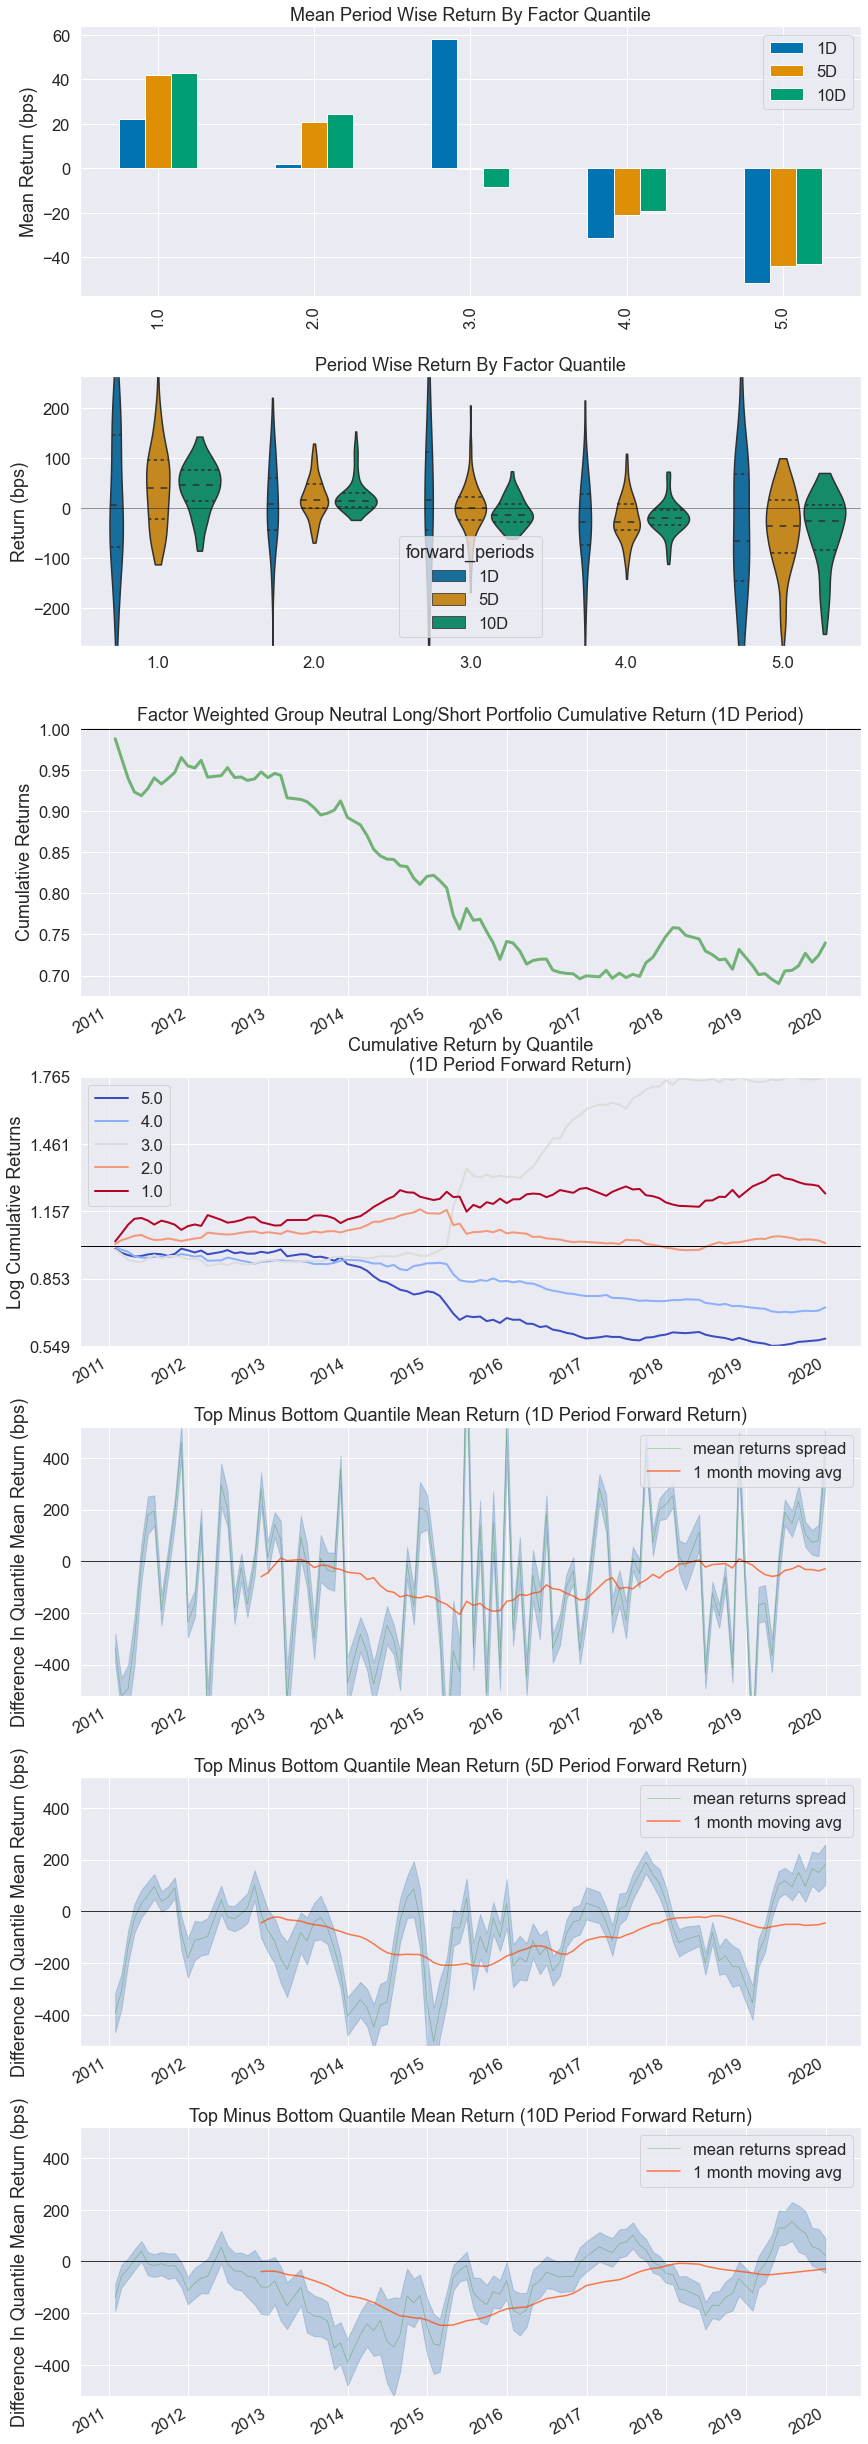

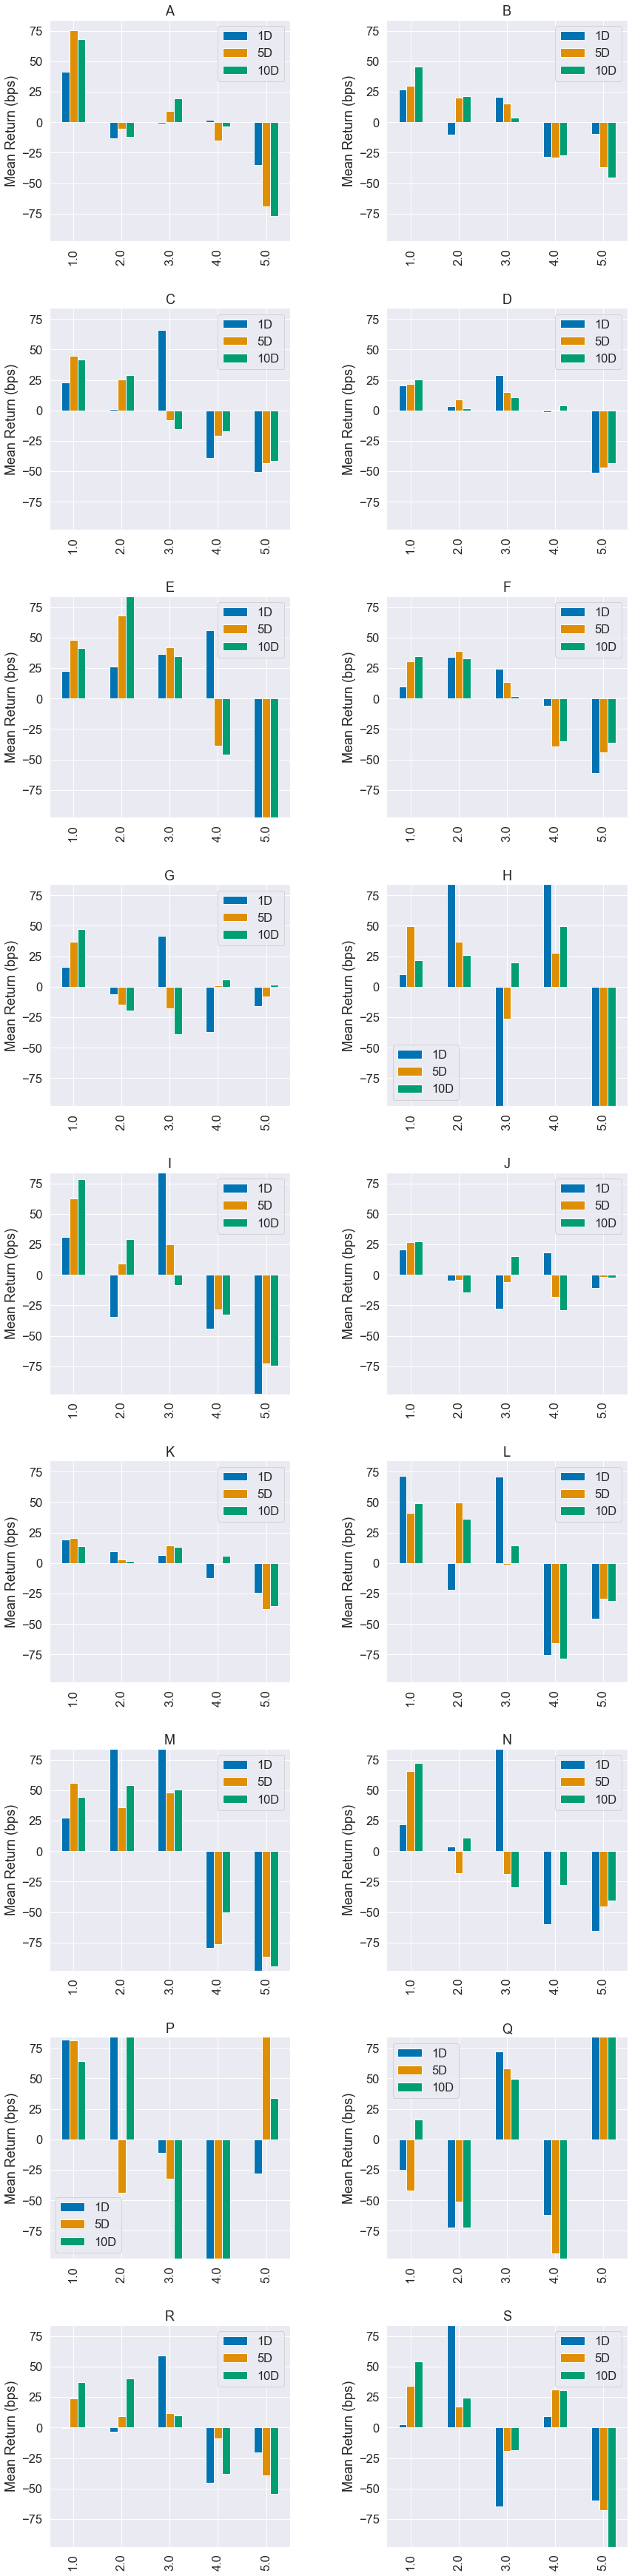

In [27]:
tears.create_returns_tear_sheet(data,group_neutral=True,by_group=True,long_short=True)

Returns Analysis


,1D,5D,10D
Ann. alpha,-0.551,-0.561,-0.592
beta,-0.040,0.011,-0.074
Mean Period Wise Return Top Quantile (bps),-51.662,-43.837,-42.803
Mean Period Wise Return Bottom Quantile (bps),22.250,42.089,42.981
Mean Period Wise Spread (bps),-73.912,-85.981,-87.025


<Figure size 432x288 with 0 Axes>

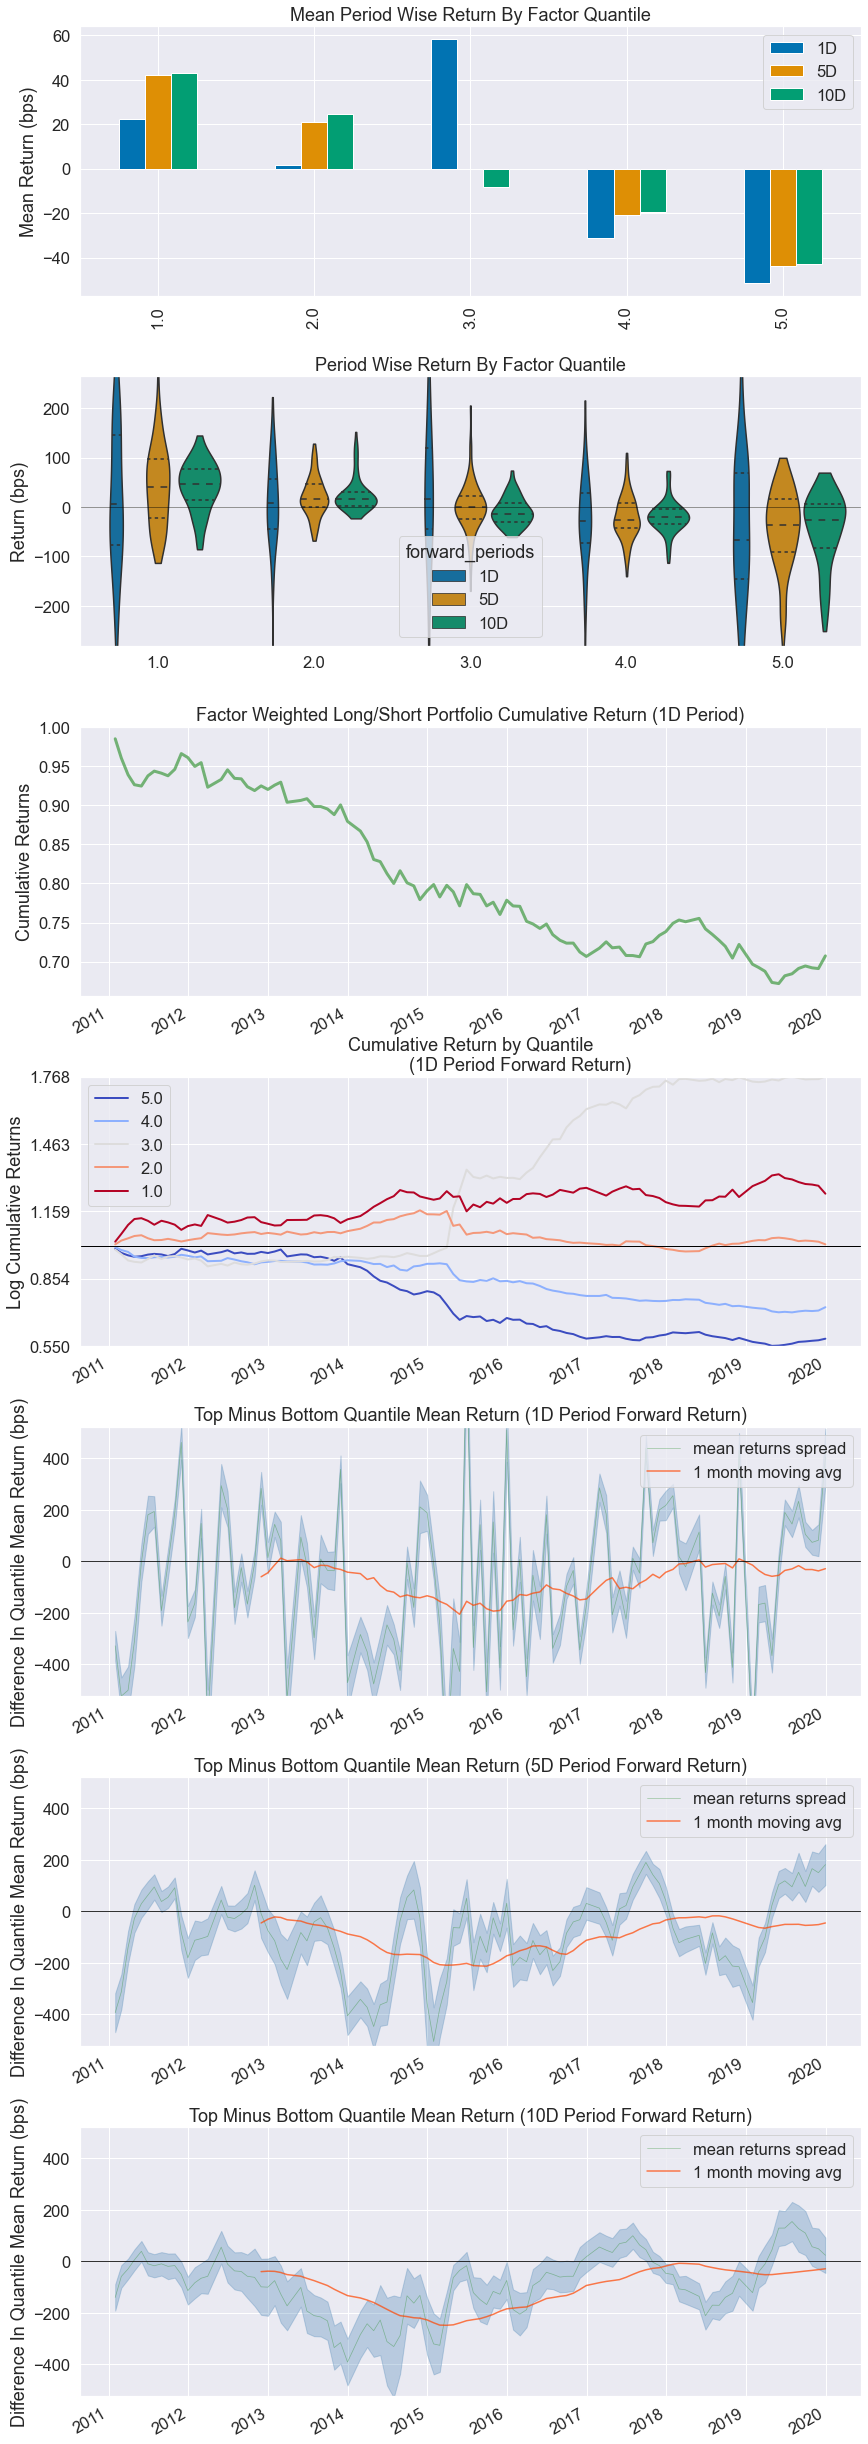

In [28]:
tears.create_returns_tear_sheet(data)

Information Analysis


,1D,5D,10D
IC Mean,-0.006,-0.054,-0.095
IC Std.,0.099,0.113,0.097
Risk-Adjusted IC,-0.058,-0.474,-0.976
t-stat(IC),-0.591,-4.785,-9.856
p-value(IC),0.556,0.000,0.000
IC Skew,0.065,-0.108,0.234
IC Kurtosis,-0.750,-0.510,-0.450


/Users/zhengboyu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/zhengboyu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/zhengboyu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 432x288 with 0 Axes>

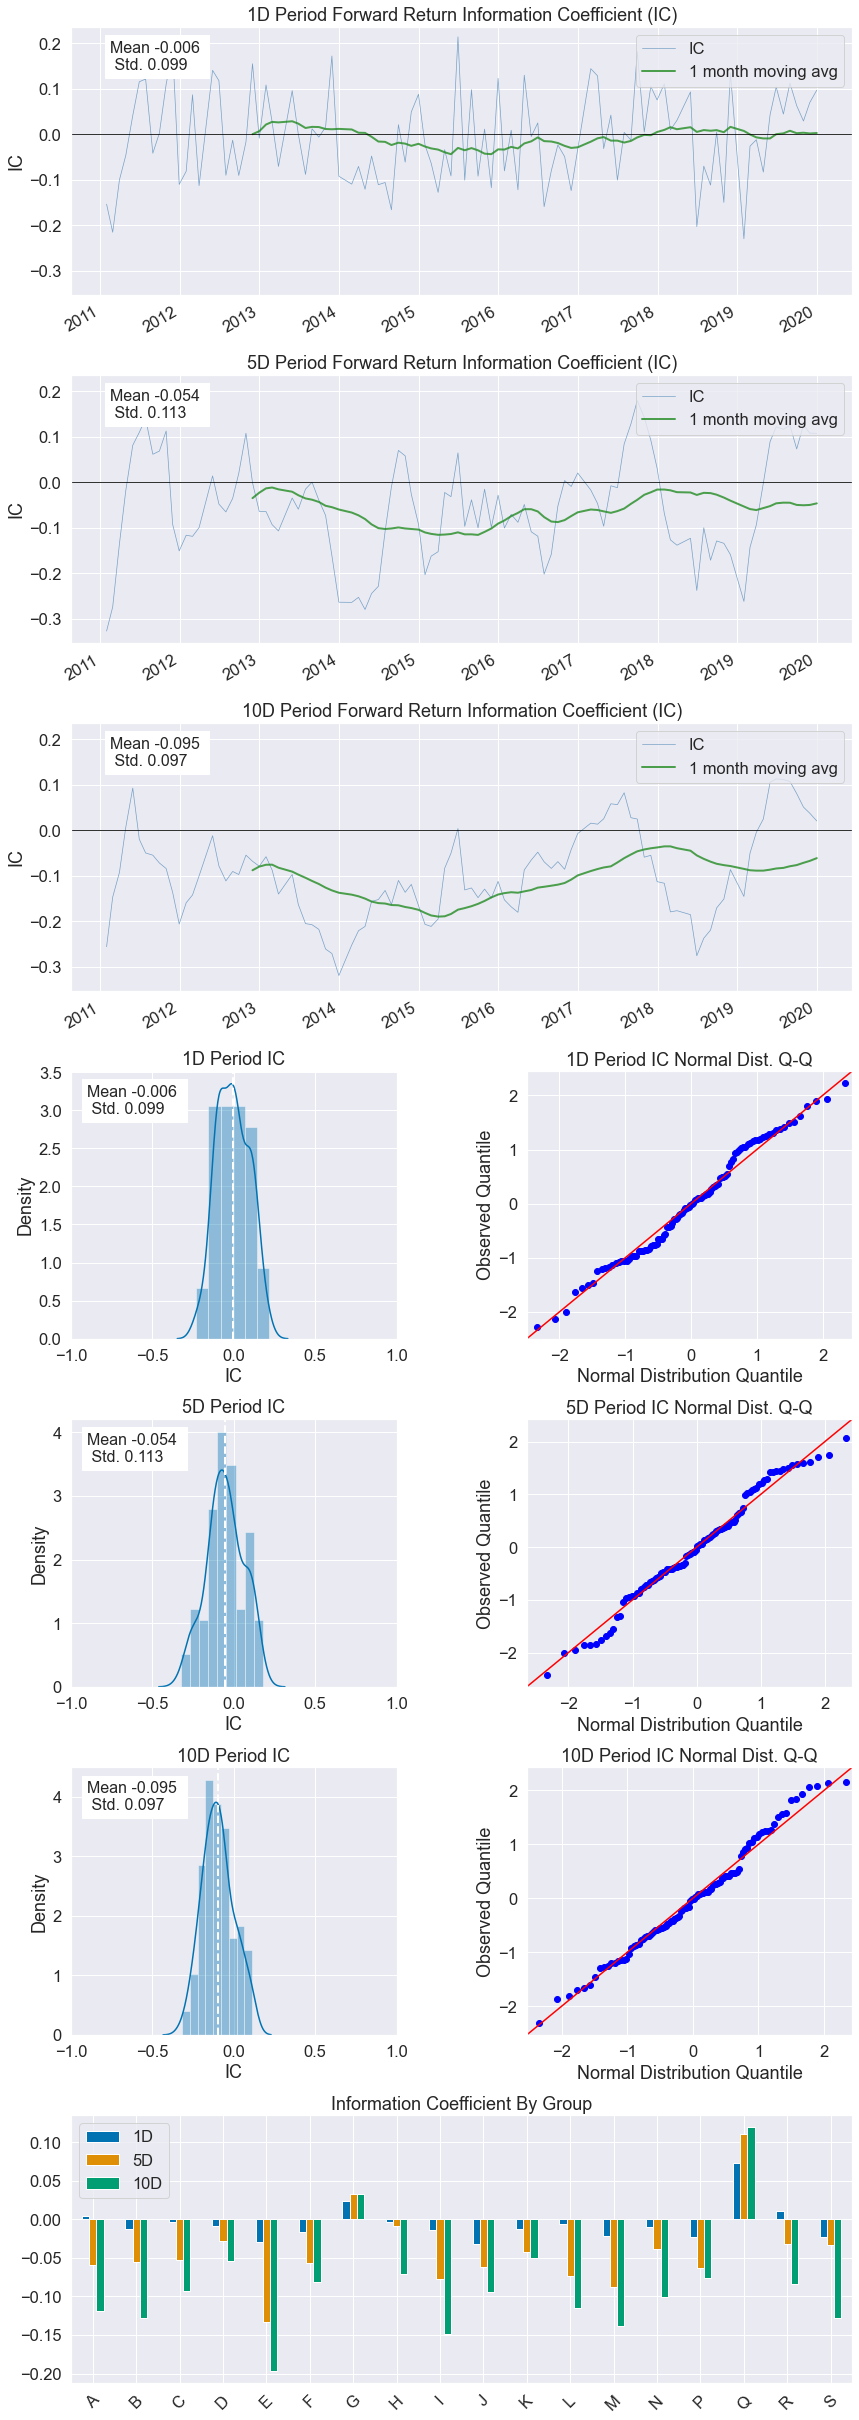

In [29]:
tears.create_information_tear_sheet(data,group_neutral=True,by_group=True)

Information Analysis


,1D,5D,10D
IC Mean,-0.008,-0.059,-0.100
IC Std.,0.103,0.118,0.104
Risk-Adjusted IC,-0.073,-0.498,-0.967
t-stat(IC),-0.741,-5.029,-9.769
p-value(IC),0.460,0.000,0.000
IC Skew,0.005,-0.084,0.340
IC Kurtosis,-0.720,-0.521,-0.336


/Users/zhengboyu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/zhengboyu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/zhengboyu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


<Figure size 432x288 with 0 Axes>

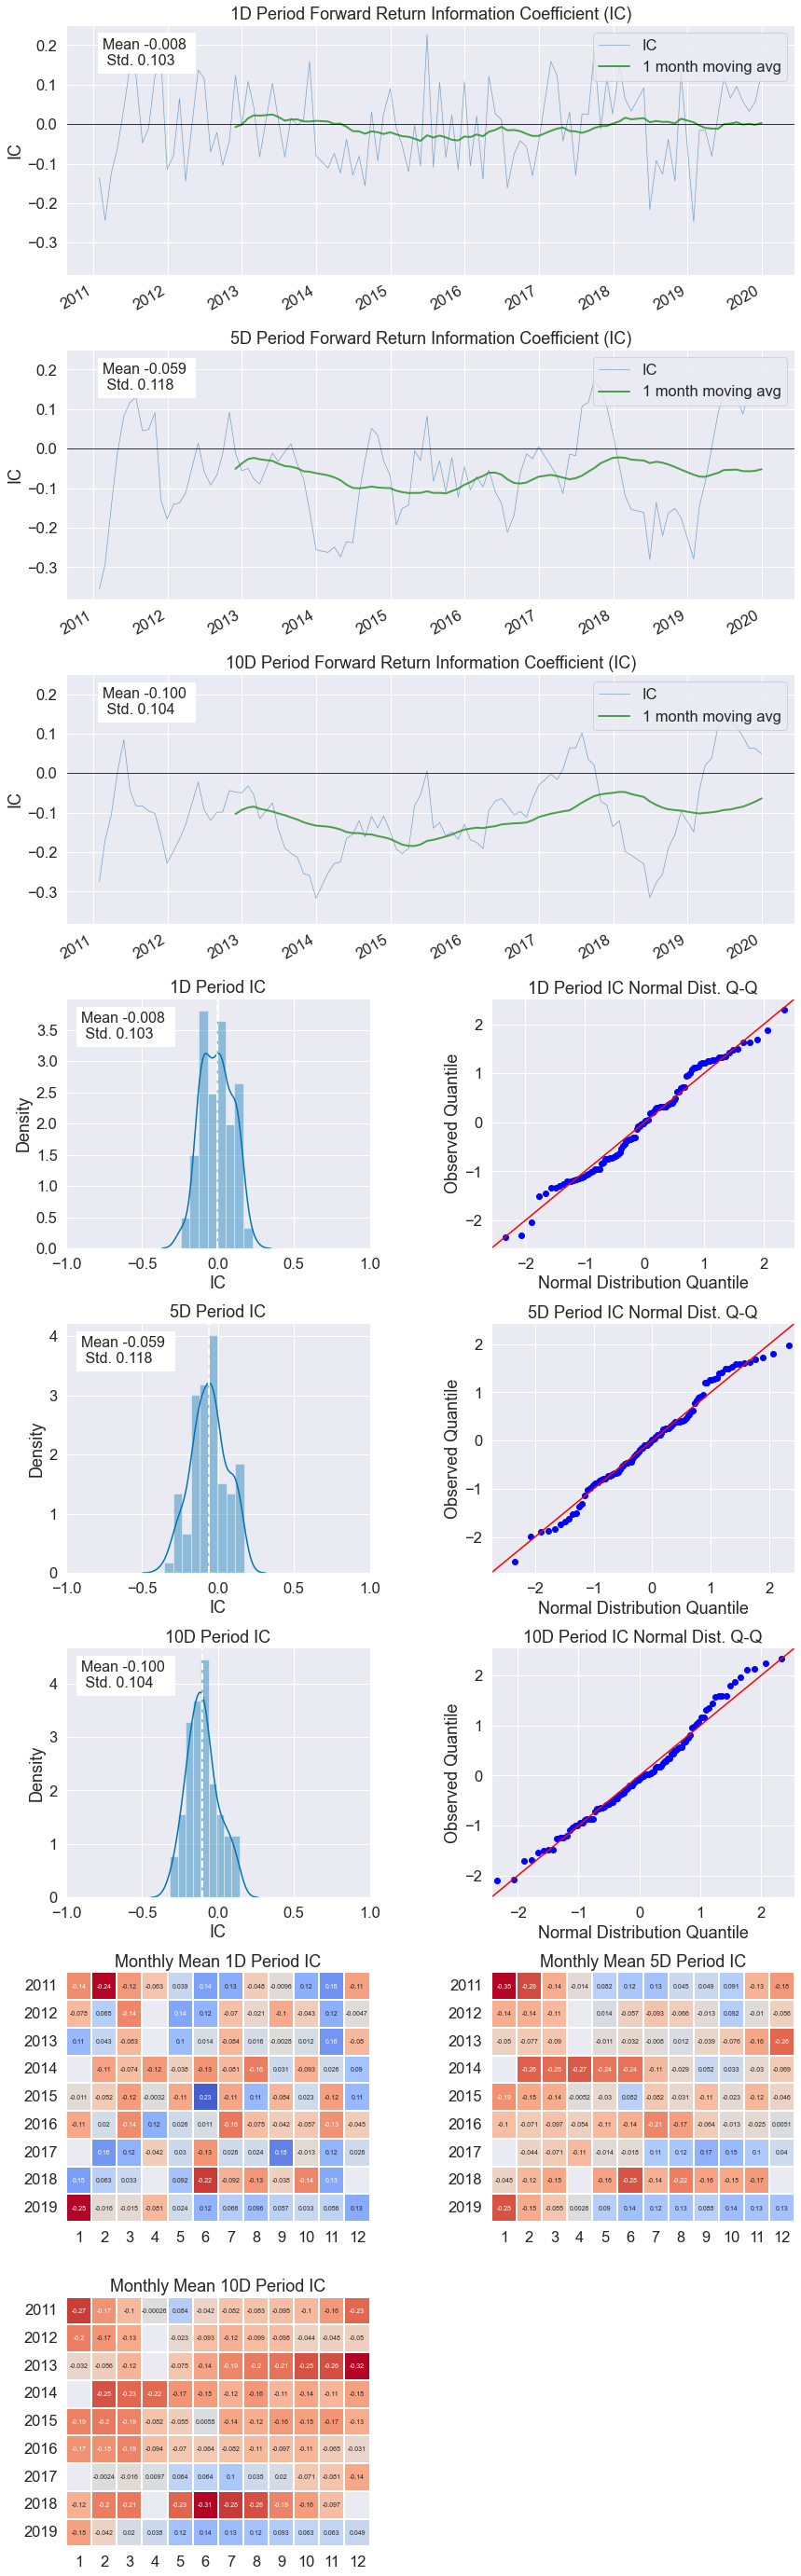

In [30]:
tears.create_information_tear_sheet(factor_data=data)

Turnover Analysis


,21D,45D,96D
Quantile 1.0 Mean Turnover,0.628,0.734,0.841
Quantile 2.0 Mean Turnover,0.720,0.789,0.855
Quantile 3.0 Mean Turnover,0.777,0.843,0.887
Quantile 4.0 Mean Turnover,0.730,0.832,0.891
Quantile 5.0 Mean Turnover,0.571,0.728,0.844


,21D,45D,96D
Mean Factor Rank Autocorrelation,0.558,0.374,0.25


<Figure size 432x288 with 0 Axes>

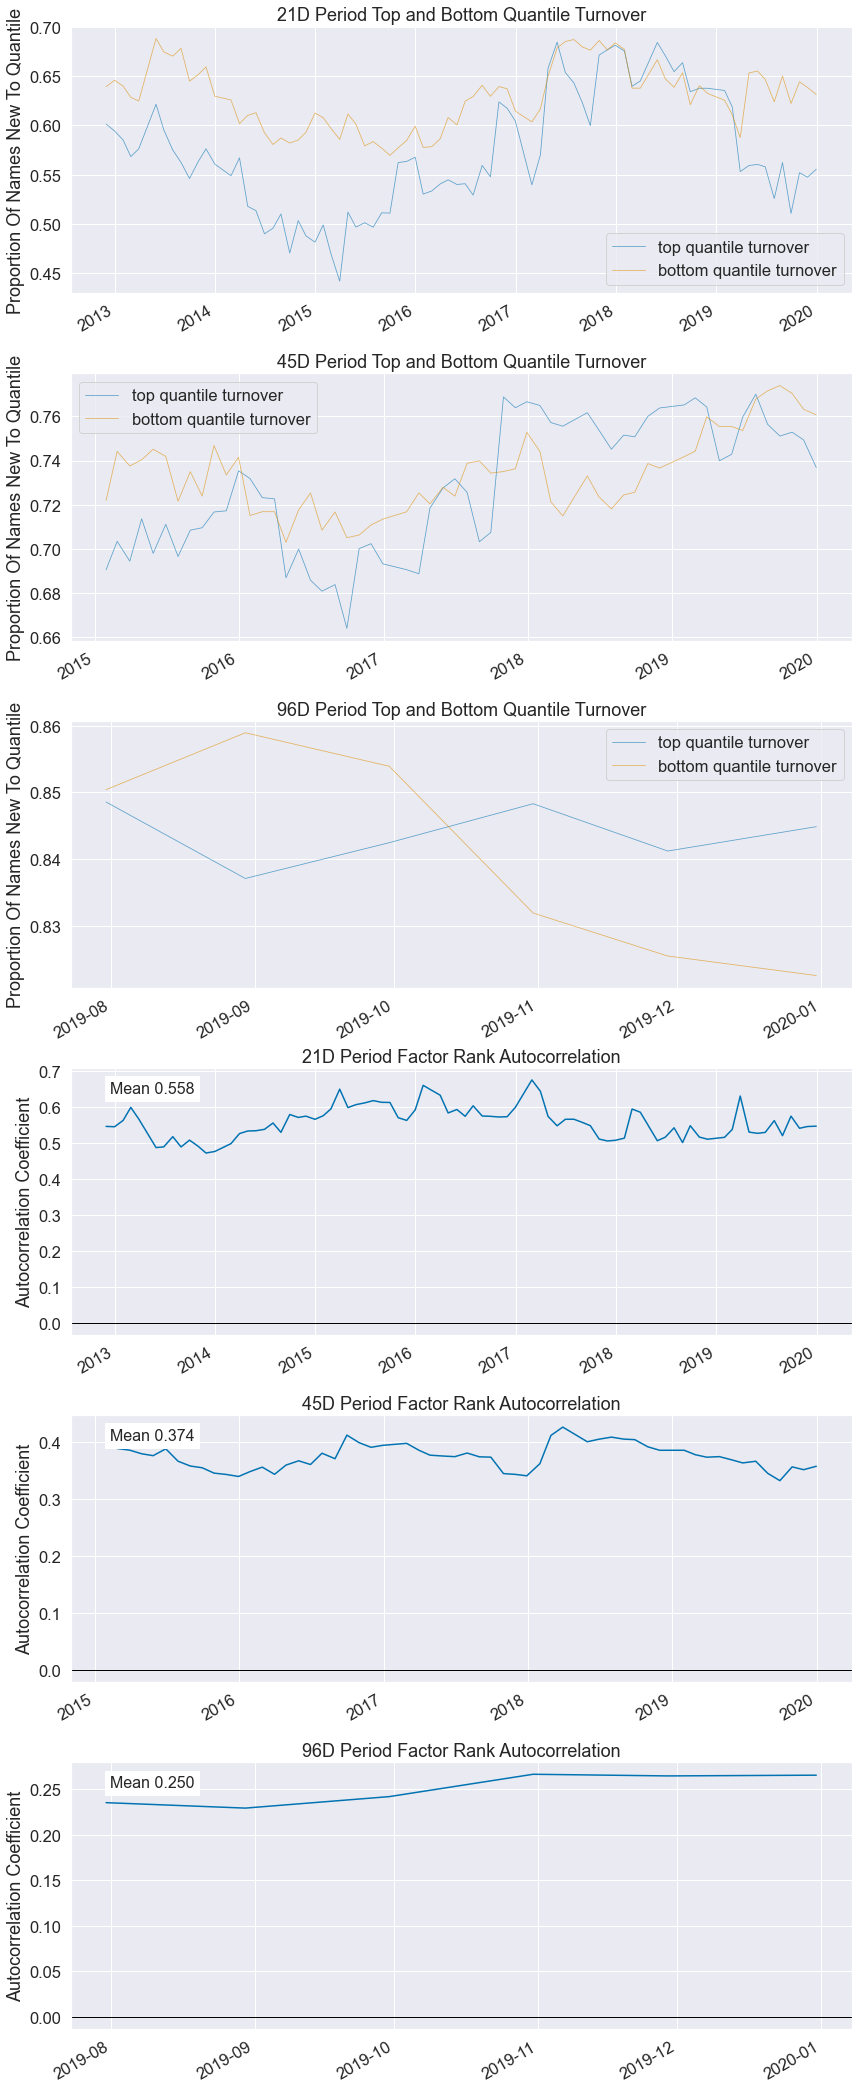

In [31]:
tears.create_turnover_tear_sheet(factor_data=data,turnover_periods=['21D','45D','96D'])